<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. 

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [4]:
import pandas as pd

data_problems = pd.read_excel('data_problems.xlsx')
data_problems_translated = pd.read_excel('data_problems_translated.xlsx')
print(data_problems.columns)
print(data_problems_translated.columns)
print(data_problems.head(2))
print(data_problems_translated.head(2))

Index(['Unnamed: 0', 'Задача', 'Тема'], dtype='object')
Index(['Unnamed: 0', 'problem_text', 'topic'], dtype='object')
   Unnamed: 0                                             Задача   Тема
0           0  Между девятью планетами Солнечной системы введ...  Графы
1           1  В стране Цифра есть 9 городов с названиями 1, ...  Графы
   Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   

           topic  
0  number_theory  
1  number_theory  


In [6]:
from transformers import AutoModel, AutoConfig
from torch import nn
from typing import Union, Dict
import torch

class TransformerClassificationModel(nn.Module):
    def __init__(
        self, 
        num_classes: int,
        base_transformer_model: Union[str, nn.Module] = 'prajjwal1/bert-tiny',
        dropout_rate: float = 0.1
    ):

        super().__init__()
        

        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
            config = AutoConfig.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model
            config = base_transformer_model.config
            

        hidden_size = config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, input_ids, attention_mask) -> Dict[str, torch.Tensor]:
        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Используем скрытое состояние [CLS] токена
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        logits = self.classifier(pooled_output)
        
        return {
            'logits': logits,
            'hidden_states': outputs.hidden_states
        }

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [7]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [8]:
import copy
import torch
from tqdm import tqdm
from torch import optim, nn
from typing import Tuple, Dict

def train_transformer(
    transformer_model: TransformerClassificationModel,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    freeze_backbone: bool = True,
    num_epochs: int = 5,
    learning_rate: float = 2e-5,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> Tuple[TransformerClassificationModel, Dict[str, list]]:
    model = copy.deepcopy(transformer_model).to(device)
    
    if freeze_backbone:
        model = freeze_backbone_function(model)
    
    # Инициализируем loss и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),  # Оптимизируем только размороженные параметры
        lr=learning_rate
    )
    
    # Планировщик 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        

        for batch in tqdm(train_loader, desc="Training"):
            inputs = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs, masks)
            loss = criterion(outputs['logits'], labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = batch['input_ids'].to(device)
                masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(inputs, masks)
                loss = criterion(outputs['logits'], labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs['logits'], 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        

        scheduler.step(val_loss)
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")
    
    return model, history

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [12]:
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split

# Параметры
model_name = "cointegrated/rubert-tiny2"
max_length = 128
batch_size = 16
num_epochs = 3 
learning_rate = 2e-5
device = torch.device("mcs" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data_problems_translated['topic'])
num_classes = len(label_encoder.classes_)

# Кастомный Dataset с приведением текста к строке
class MathProblemsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Делим данные на train/val (80/20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_problems_translated["problem_text"].tolist(),
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# DataLoaders
train_dataset = MathProblemsDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = MathProblemsDataset(val_texts, val_labels, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 1. Дообучение с замороженным backbone
rubert_tiny_model_freezed = TransformerClassificationModel(num_classes, base_transformer_model=model_name)
rubert_tiny_finetuned_with_freezed_backbone, history_freezed = train_transformer(
    rubert_tiny_model_freezed, train_loader, val_loader,
    freeze_backbone=True,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

# 2. Дообучение с размороженным backbone
rubert_tiny_model_unfrozen = TransformerClassificationModel(num_classes, base_transformer_model=model_name)
rubert_tiny_full_finetuned, history_unfrozen = train_transformer(
    rubert_tiny_model_unfrozen, train_loader, val_loader,
    freeze_backbone=False,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)


Epoch 1/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 36.47it/s]


Train loss: 1.9433 | Val loss: 1.8226 | Val accuracy: 0.2929
Epoch 2/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 34.76it/s]


Train loss: 1.7533 | Val loss: 1.6775 | Val accuracy: 0.4531
Epoch 3/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 34.03it/s]


Train loss: 1.6320 | Val loss: 1.5965 | Val accuracy: 0.4588
Epoch 1/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.17it/s]


Train loss: 1.3617 | Val loss: 1.1398 | Val accuracy: 0.5896
Epoch 2/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 30.30it/s]


Train loss: 1.0821 | Val loss: 1.0216 | Val accuracy: 0.6028
Epoch 3/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 31.93it/s]

Train loss: 0.9635 | Val loss: 0.9912 | Val accuracy: 0.6114


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [14]:
# Параметры для модели MathBert
model_name_mathbert = "tbs17/MathBert"
tokenizer_mathbert = AutoTokenizer.from_pretrained(model_name_mathbert)

# Создаем DataLoader'ы для MathBert, переиспользуя ранее определённый класс MathProblemsDataset
train_dataset_mathbert = MathProblemsDataset(train_texts, train_labels, tokenizer_mathbert, max_length)
val_dataset_mathbert = MathProblemsDataset(val_texts, val_labels, tokenizer_mathbert, max_length)

train_loader_mathbert = DataLoader(train_dataset_mathbert, batch_size=batch_size, shuffle=True)
val_loader_mathbert = DataLoader(val_dataset_mathbert, batch_size=batch_size)

# 1. Обучение tbs17/MathBert с замороженным backbone
try:
    mathbert_model_freezed = TransformerClassificationModel(num_classes, base_transformer_model=model_name_mathbert)
    mathbert_finetuned_freezed, history_mathbert_freezed = train_transformer(
        mathbert_model_freezed,
        train_loader_mathbert,
        val_loader_mathbert,
        freeze_backbone=True,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device
    )
    print("Замороженный backbone успешно обучен")
except Exception as e:
    print("Ошибка при загрузке или обучении модели tbs17/MathBert (freeze=True):", e)

# 2. Обучение tbs17/MathBert с размороженным backbone
try:
    mathbert_model_unfrozen = TransformerClassificationModel(num_classes, base_transformer_model=model_name_mathbert)
    mathbert_finetuned_unfrozen, history_mathbert_unfrozen = train_transformer(
        mathbert_model_unfrozen,
        train_loader_mathbert,
        val_loader_mathbert,
        freeze_backbone=False,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device
    )
    print("Размороженный backbone успешно обучен")
except Exception as e:
    print("Ошибка при загрузке или обучении модели tbs17/MathBert (freeze=False):", e)
#Остановка из-за ограничений компьютера

pytorch_model.bin:  83%|########3 | 367M/441M [00:00<?, ?B/s]

Epoch 1/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:33<00:00,  1.99it/s]


Train loss: 1.8662 | Val loss: 1.6403 | Val accuracy: 0.4246
Epoch 2/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:37<00:00,  1.78it/s]


Train loss: 1.6259 | Val loss: 1.5835 | Val accuracy: 0.4313
Epoch 3/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:38<00:00,  1.72it/s]


Train loss: 1.5770 | Val loss: 1.5475 | Val accuracy: 0.4322
Замороженный backbone успешно обучен
Epoch 1/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:39<00:00,  1.66it/s]


Train loss: 1.1805 | Val loss: 0.9927 | Val accuracy: 0.6199
Epoch 2/3


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:40<00:00,  1.63it/s]


Train loss: 0.8821 | Val loss: 1.0338 | Val accuracy: 0.5962
Epoch 3/3


Training:   5%|██████▌                                                                                                                    | 14/264 [00:46<13:52,  3.33s/it]


KeyboardInterrupt: 

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания и протестируйте ее на примере.

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


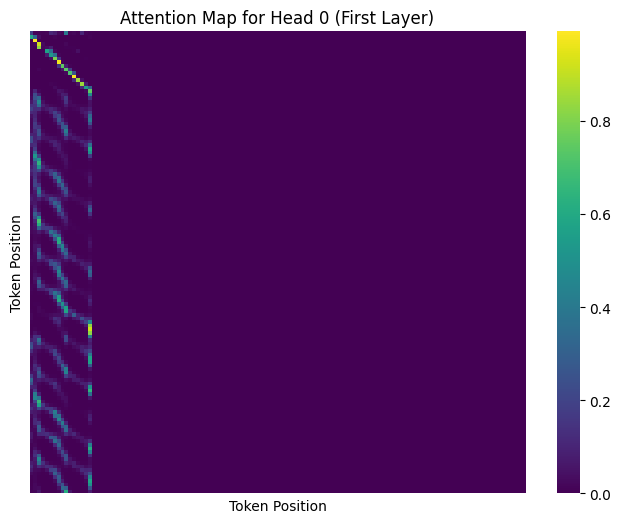

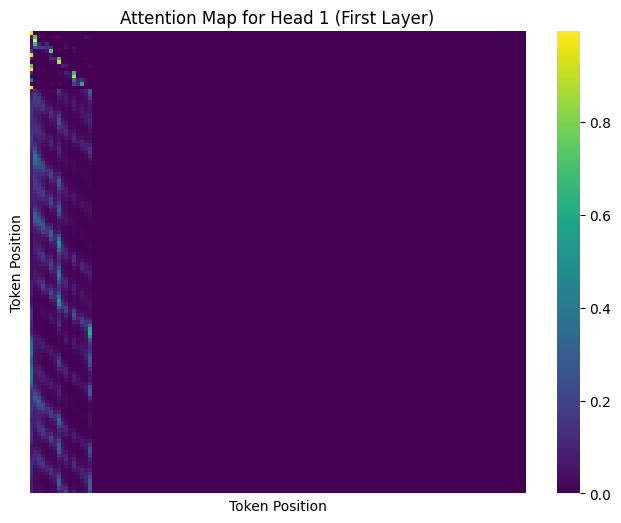

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoTokenizer

def draw_first_layer_attention_maps(attention_head_ids: list, text: str, model: TransformerClassificationModel):
    device = next(model.parameters()).device
    # Создаем токенизатор, используя тот же базовый идентификатор модели, что и у backbone
    tokenizer = AutoTokenizer.from_pretrained(model.backbone.config._name_or_path)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Прямой проход через backbone с включенной выдачей attentions
    outputs = model.backbone(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        output_attentions=True,
        return_dict=True
    )


    first_layer_attentions = outputs.attentions[0][0]  # (num_heads, seq_len, seq_len)

    # Отрисовываем карты для выбранных attention-head'ов
    for head in attention_head_ids:
        if head < first_layer_attentions.shape[0]:
            attn_map = first_layer_attentions[head].detach().cpu().numpy()
            plt.figure(figsize=(8, 6))
            sns.heatmap(attn_map, cmap="viridis", xticklabels=False, yticklabels=False)
            plt.title(f"Attention Map for Head {head} (First Layer)")
            plt.xlabel("Token Position")
            plt.ylabel("Token Position")
            plt.show()
        else:
            print(f"Индекс head {head} вне диапазона. Всего heads: {first_layer_attentions.shape[0]}")


#пример
example_text = "Доказать, что сумма двух чётных чисел является чётным числом."
attention_head_ids = [0, 1]
draw_first_layer_attention_maps(attention_head_ids, example_text, rubert_tiny_finetuned_with_freezed_backbone)


### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)


--- Attention-карты для модели cointegrated/rubert-tiny2 ---

Текст 1: To prove that the sum of the numbers of the exact square cannot be equal to 5.



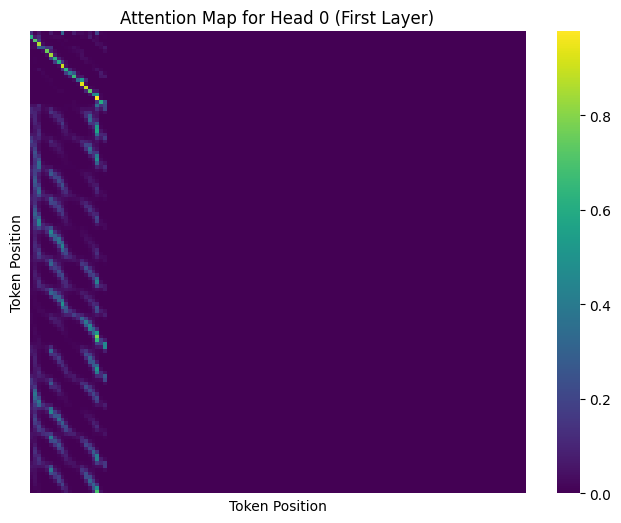

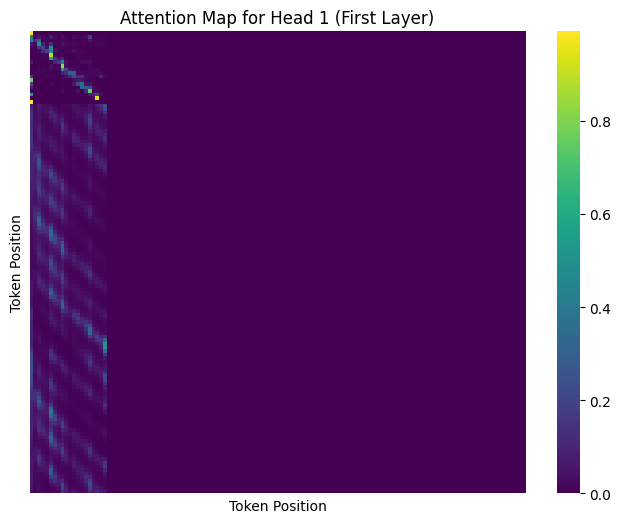


Текст 2: ( b) Will the statement of the previous challenge remain true if Petia and Wasa originally planned four natural numbers?



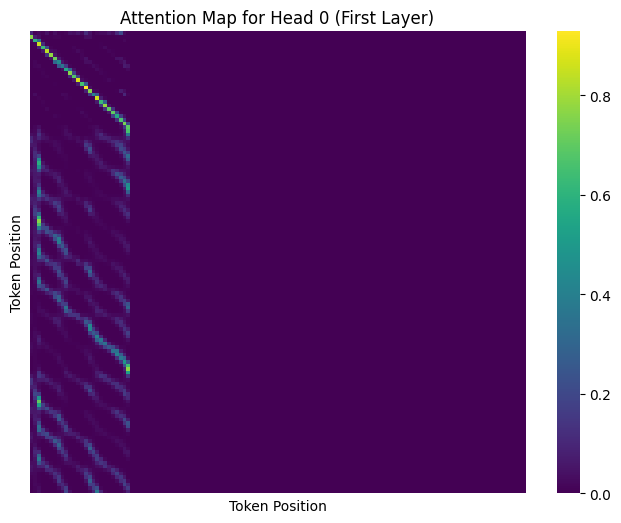

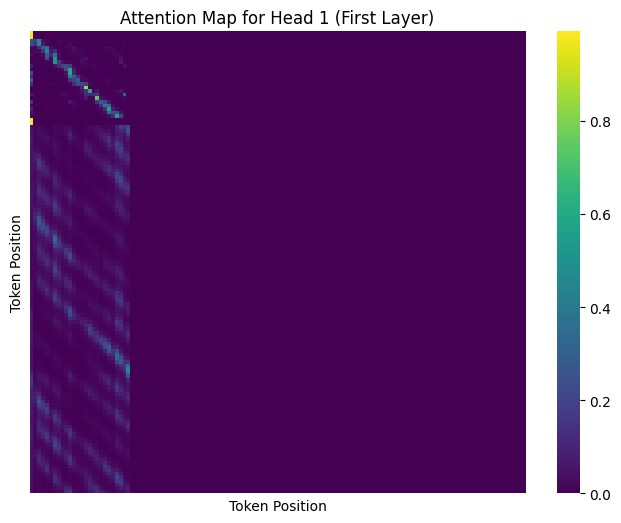


Текст 3: The quadratic three-member graph with the coefficients has two points with the coordinates. Show that if the distance between them is the whole number, then the fraction is parallel to the abscisse axis.



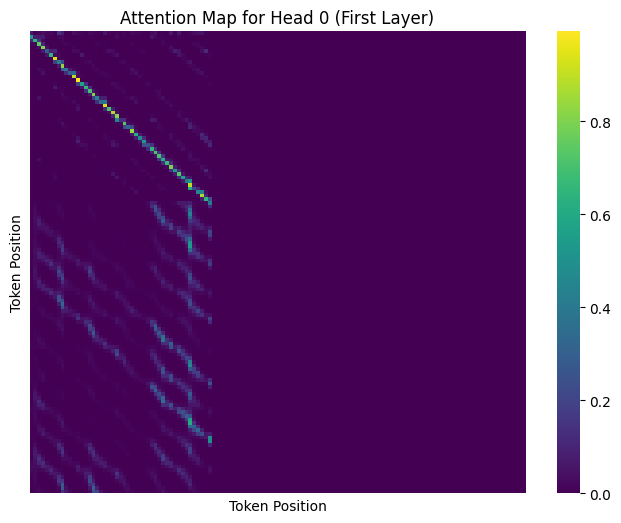

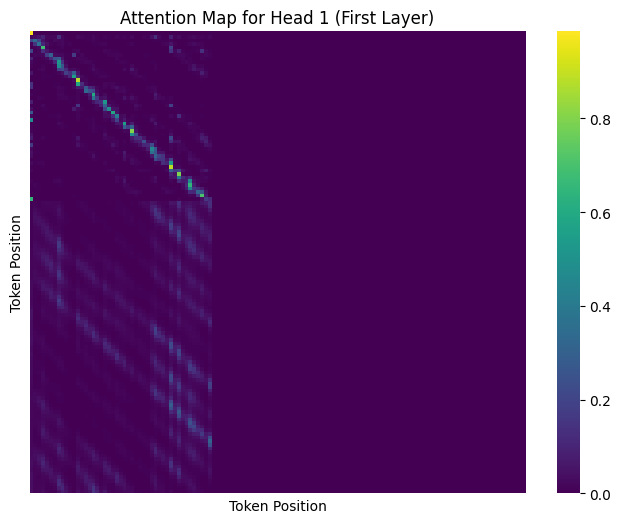


--- Attention-карты для модели tbs17/MathBert ---

Текст 1: To prove that the sum of the numbers of the exact square cannot be equal to 5.



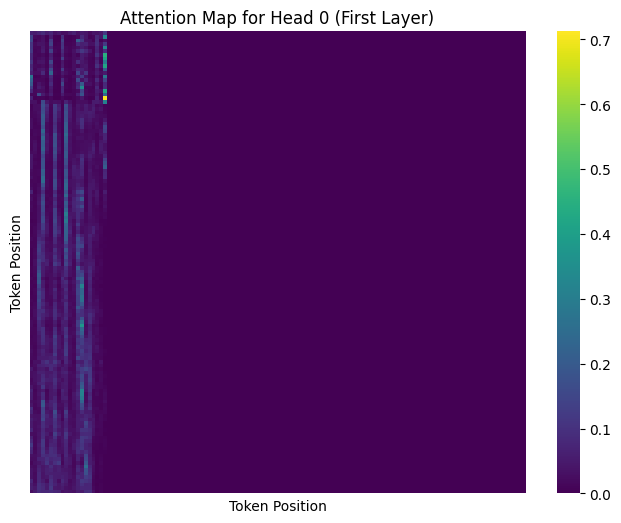

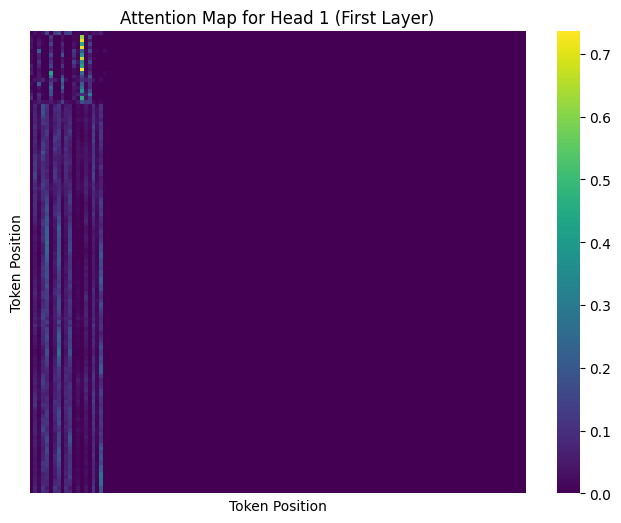


Текст 2: ( b) Will the statement of the previous challenge remain true if Petia and Wasa originally planned four natural numbers?



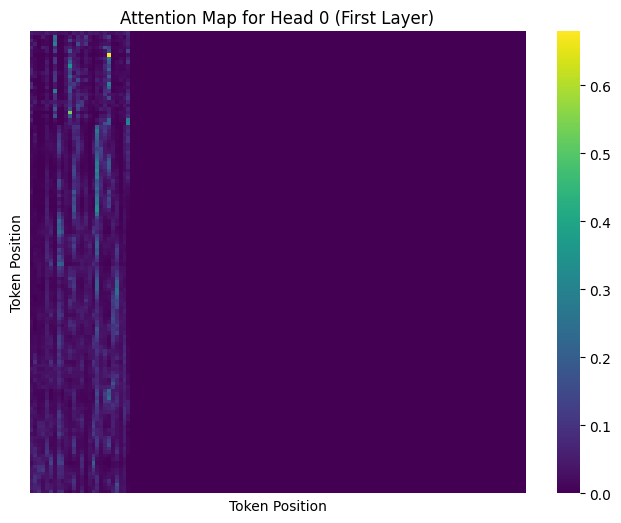

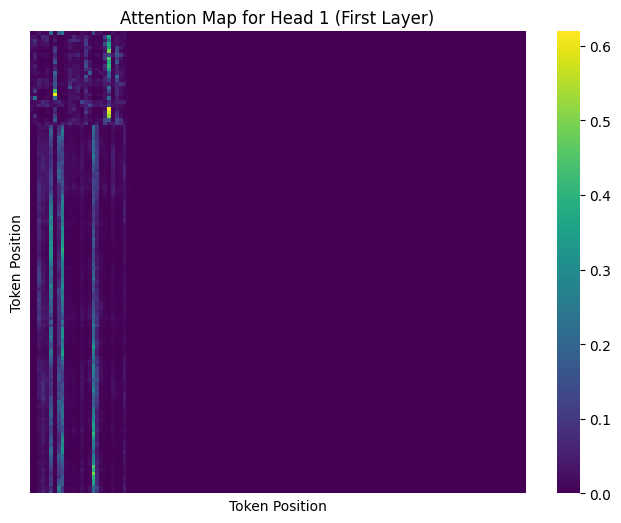


Текст 3: The quadratic three-member graph with the coefficients has two points with the coordinates. Show that if the distance between them is the whole number, then the fraction is parallel to the abscisse axis.



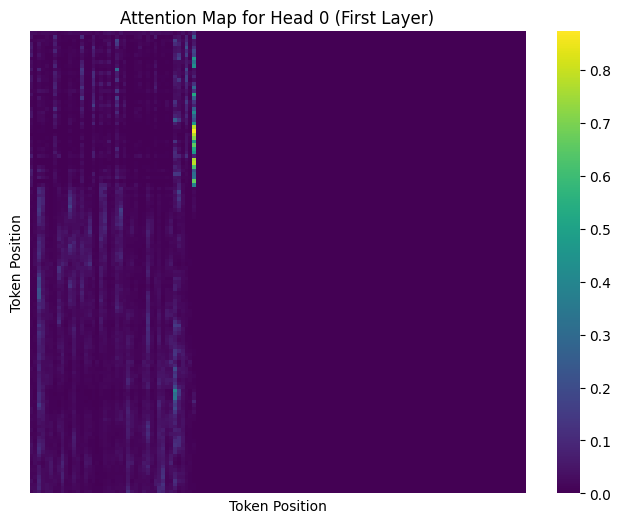

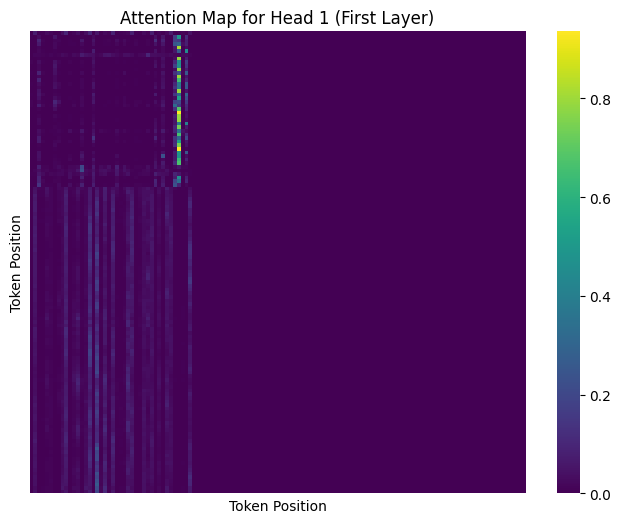

In [28]:
sample_texts = [
    data_problems_translated["problem_text"].iloc[0],
    data_problems_translated["problem_text"].iloc[1],
    data_problems_translated["problem_text"].iloc[2]
]

# Задаем индексы attention-head'ов для визуализации (можно выбрать наиболее интересные)
attention_head_ids = [0, 1] 
model_name_rubert = "cointegrated/rubert-tiny2"
rubert_tiny_pretrained = TransformerClassificationModel(num_classes, base_transformer_model=model_name_rubert)


# Загрузка предобученной модели MathBert до дообучения
model_name_mathbert = "tbs17/MathBert"
mathbert_pretrained = TransformerClassificationModel(num_classes, base_transformer_model=model_name_mathbert)

# Функция для проведения инференса и отрисовки attention-карт для заданной модели
def infer_and_draw_attention(model, model_name):
    print(f"\n--- Attention-карты для модели {model_name} ---")
    for i, text in enumerate(sample_texts):
        print(f"\nТекст {i+1}: {text}\n")
        # Отрисовываем
        draw_first_layer_attention_maps(attention_head_ids, text, model)


infer_and_draw_attention(rubert_tiny_pretrained, model_name_rubert)
infer_and_draw_attention(mathbert_pretrained, model_name_mathbert)
